In [8]:
import datetime
import json
import os
from collections import defaultdict
import gc
from joblib import dump, load
import random
import time
from typing import List, Tuple

from albumentations import (
    Compose, Flip, Rotate
)

import cv2
import dask
import dask.array as da

from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, precision_recall_fscore_support, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.applications import inception_v3, resnet_v2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import Accuracy, binary_crossentropy

from data_engineering.dask_image_stats_collector import stats_for_numpy_images 
from data_science.keras.dataset import get_image_dataset, get_predictions_for_dataset
from data_science.graph_utils import graph_model_history
from data_science.keras.model_checkpoint_gcs import ModelCheckpointGCS
from data_science.keras.cnn_models import basic_cnn_model, basic_cnn_model_with_regularization, pretrained_model
from data_science.serialization_utils import numpy_to_json, sklearn_precision_recall_curve_to_dict
from data_science.sklearn_batch_generator import SklearnBatchGenerator
from data_science.train import get_model_and_metadata_from_gcs, train_keras_model

In [43]:
root = '/home/jovyan/work/data/big_earth'
os.listdir(root)

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/app/.gcs/big-earth-252219-fb2e5c109f78.json'
gcs_client = storage.Client()
bucket = gcs_client.bucket("big_earth")

n_classes = 1
n_epochs = 100
batch_size = 128

early_stopping_patience = 6
use_small_dataset = False
use_random_small_dataset = False

project_name = "cloud_and_shadow"
model_dir = os.path.join(root, "model/models")
log_dir = os.path.join(root, "model/logs")
# blob prefix
gcs_model_dir = "model/models"
# tensorboard
gcs_log_dir = "gs://big_earth/model/logs"

for directory in [log_dir, model_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        
        
# np.array(json.loads(df['binarized_labels'].iloc[0])).shape

def prepare_data(df):
    df['has_cloud_and_shadow_target'] = df['has_cloud_and_shadow_target'].apply(lambda x: np.array(json.loads(x)))
    df['binarized_labels'] = df['binarized_labels'].apply(lambda x: np.array(json.loads(x)))    
    df['image_path'] = root + "/npy_image_files/" + df['image_prefix'] + ".npy"
    return df

df = pd.read_csv(root + "/metadata/metadata.csv")
df = prepare_data(df)
print(df['binarized_labels'].iloc[0].shape)
print(df['has_cloud_and_shadow_target'].iloc[0].shape)
df = df.set_index('image_prefix', drop=False)

if use_small_dataset:
    google_automl_dataset = pd.read_csv( '/app/data_science/google_automl_cloud_and_shadow_dataset_small.csv')
    band_stats = pd.read_csv('/app/data_science/cloud_and_shadow_stats_small_train.csv')
    band_stats[band_stats['dataset'] == 'all_small']
else:
    google_automl_dataset = pd.read_csv( '/app/data_science/google_automl_dataset_large.csv')
    band_stats = pd.read_csv('/app/data_science/cloud_and_shadow_stats_large_train.csv')
    band_stats[band_stats['dataset'] == 'all_large']
    
google_automl_dataset['image_prefix'] = google_automl_dataset['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
google_automl_dataset = google_automl_dataset.set_index('image_prefix', drop=False)

train = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TRAIN'].index]
valid = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'VALIDATION'].index]
test = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TEST'].index]

print(len(train), len(valid), len(test))
print(len(train) + len(valid) + len(test) == len(google_automl_dataset))   

x_train = train['image_path'].values
x_valid = valid['image_path'].values
x_test = test['image_path'].values

target = 'has_cloud_and_shadow_target'
y_train = np.stack(train[target].values)
y_valid = np.stack(valid[target].values)
y_test = np.stack(test[target].values)

print(y_train.shape, y_train[0].shape)

(1, 44)
(1,)
14896 1824 1840
True
(14896, 1) (1,)


In [34]:
experiment_name = f"{project_name}_keras_cnn_bn_aug_2020_2_14"
model, model_base_metadata = get_model_and_metadata_from_gcs(
    bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)

In [ ]:
import numpy as np


def plot_activations(model, img):
    layer_names = []
    for layer in model.layers:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 12
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)    
    activations = activation_model.predict(img)
    activations = activations
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        if not 'conv2d' in layer_name:
            continue
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
x_small = [x_train[5]]
y_small = [y_train[5]]     
train_batch_generator = get_image_dataset(x_small, y_small, augmentations=None, band_stats=stats, 
                                          batch_size=batch_size)
img, label = train_batch_generator.make_one_shot_iterator().get_next()

plot_activations(model, img)

In [ ]:
rgb_img = (img[0].numpy() * 1.6 * 256.).astype(np.int8)
plt.imshow(rgb_img)

binary_crossentropy - cnn with regularization and augmentation 0.2838938
accuracy 0.8625


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b1074c630>]],
      dtype=object)

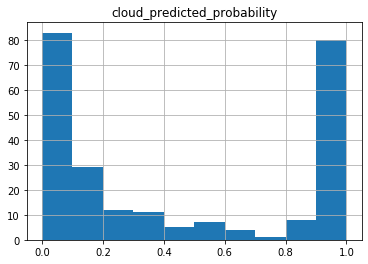

In [35]:
test_generator = get_image_dataset(x=x_test, y=y_test, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
y_actual_test, y_pred_test, y_pred_probs_test = get_predictions_for_dataset(test_generator, model) 

print('binary_crossentropy - cnn with regularization and augmentation', 
      binary_crossentropy(y_actual_test, y_pred_probs_test).numpy())
print('accuracy', accuracy_score(y_actual_test, y_pred_test))

pd.DataFrame({'cloud_predicted_probability': y_pred_probs_test}).hist()

In [46]:
band_stats = pd.read_csv(root + '/cloud_and_shadow_stats_small_train.csv')
band_stats

,Unnamed: 0,mean,std,min,max,dataset
0,red,1037.286040,1904.295943,0,18946,small_train
1,blue,1151.790453,1750.604182,0,17921,small_train
2,green,1104.914808,1826.425950,0,17064,small_train


In [13]:
experiments = [
    "keras_cnn_bn_2020_2_14",
    "keras_cnn_bn_aug_2020_2_14",
    "keras_cnn_bn_dropout_aug_2020_2_14"
]

len_one_keys = ['data', 'data_prep', 'experiment_name', 'experiment_start_time', 'model', 'random_state', 'epoch_with_best_model', 'epochs_trained', 'optimizer', 'n_epochs', 'early_stopping_patience', 'learning_rate', 'elapsed_train_time', 'accuracy_train', 'f1_score_train', 'train_loss', 'loss', 'accuracy_valid', 'f1_score_valid']
long_keys = ['history', 'confusion_matrix', 'precision_recall_curve', 'y_actual_train', 'y_pred_train', 'y_pred_probs_train', 'y_actual_valid', 'y_pred_valid', 'y_pred_probs_valid']
serializable_results_list = []

for experiment in experiments:
    experiment = f"{project_name}_{experiment}"
    local_filename = f'/tmp/{experiment}.json'
    blob = bucket.blob(f"model/models/{experiment}_metadata.json")
    blob.download_to_filename(local_filename)

    with open(local_filename) as fileobj:
        results = json.load(fileobj)  

    try:
        serializable_results = {k: results[k] for k in len_one_keys}
        for key in long_keys:
            serializable_results[key] = json.dumps(results[key])
        serializable_results_list.append(serializable_results)
    except KeyError:
        print('keyerror')
        print(experiment)
    
df = pd.DataFrame(serializable_results_list, index=[num for num in range(len(serializable_results_list))])

,data,data_prep,experiment_name,experiment_start_time,model,random_state,epoch_with_best_model,epochs_trained,optimizer,n_epochs,...,f1_score_valid,history,confusion_matrix,precision_recall_curve,y_actual_train,y_pred_train,y_pred_probs_train,y_actual_valid,y_pred_valid,y_pred_probs_valid
0,train_valid_google_automl_cloud_and_shadow_dat...,normalization_augmentation,cloud_and_shadow_keras_cnn_bn_2020_2_14,2020-02-14 19:47,keras_cnn_bn,0,47,68,Adam,100,...,0.835681,"{""loss"": [0.5559464807934204, 0.35107554042908...","""{\""data\"": [[129, 8], [27, 89]], \""shape\"": [...","{""precision"": ""{\""data\"": [0.45849802371541504...","[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...","[0.9757316708564758, 0.0007789134979248047, 0....","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...","[0.9318985342979431, 0.9508774280548096, 0.003..."
1,train_valid_google_automl_cloud_and_shadow_dat...,normalization_augmentation,cloud_and_shadow_keras_cnn_bn_aug_2020_2_14,2020-02-14 20:00,keras_cnn_bn,0,39,60,Adam,100,...,0.921053,"{""loss"": [0.7740095957574509, 0.47752618803737...","""{\""data\"": [[130, 7], [11, 105]], \""shape\"": ...","{""precision"": ""{\""data\"": [0.45849802371541504...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, ...","[0.22297978401184082, 0.985474705696106, 0.011...","[1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0.9997086524963379, 0.062342941761016846, 0.0..."
2,train_valid_google_automl_cloud_and_shadow_dat...,normalization_augmentation,cloud_and_shadow_keras_cnn_bn_dropout_aug_2020...,2020-02-14 20:08,keras_cnn_bn_dropout,0,45,66,Adam,100,...,0.916300,"{""loss"": [0.5605394275137187, 0.42890080101651...","""{\""data\"": [[130, 7], [12, 104]], \""shape\"": ...","{""precision"": ""{\""data\"": [0.45849802371541504...","[0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, ...","[0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, ...","[0.0020144283771514893, 0.00021651387214660645...","[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0.997240424156189, 0.9963773488998413, 0.9999..."


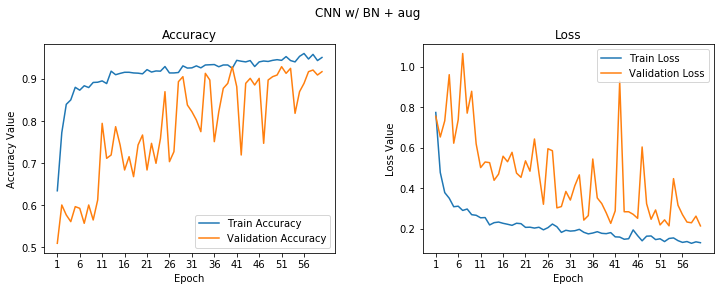

In [29]:
graph_model_history(json.loads(
    df[df['experiment_name'] == 'cloud_and_shadow_keras_cnn_bn_aug_2020_2_14'].iloc[0].to_dict()['history']),
                    'CNN w/ BN + aug'
)

In [ ]:
graph_model_history()

In [15]:
df.columns
df[['experiment_name', 'optimizer', 'learning_rate', 'elapsed_train_time', 'n_epochs', 'accuracy_train', 'accuracy_valid']].sort_values(
    by='accuracy_valid', ascending=False)

,experiment_name,optimizer,learning_rate,elapsed_train_time,n_epochs,accuracy_train,accuracy_valid
1,cloud_and_shadow_keras_cnn_bn_aug_2020_2_14,Adam,0.0003,454.221244,100,0.927635,0.928854
2,cloud_and_shadow_keras_cnn_bn_dropout_aug_2020...,Adam,0.0003,524.862098,100,0.947562,0.924901
0,cloud_and_shadow_keras_cnn_bn_2020_2_14,Adam,0.0003,497.685306,100,0.999476,0.861660


In [6]:
experiments = [
    "cloud_and_shadow_basic_cnn_2020_1_31",
    "cloud_and_shadow_basic_cnn_aug_bn_dropout_2020_2_12",
    "cloud_and_shadow_basic_cnn_best_practices_2020_1_31",
    "cloud_and_shadow_basic_cnn_with_regularization_2020_1_31",
    "cloud_and_shadow_basic_cnn_with_regularization_and_aug_2020_1_31",
#     "cloud_and_shadow_inception_v3_with_aug_2020_2_08",
#     "cloud_and_shadow_inception_v3_with_aug_lr_1e-6_2020_2_08",
#     "cloud_and_shadow_resnet_v2_with_aug_2020_2_08",
#     "cloud_and_shadow_resnet_v2_with_aug_early_stopping_15_2020_2_08",
#     "cloud_and_shadow_resnet_v2_with_aug_early_stopping_20_lr_3e-4_2020_2_08",
]


len_one_keys = ['data', 'data_prep', 'experiment_name', 'experiment_start_time', 'model', 'random_state', 'epoch_with_best_model', 'epochs_trained', 'optimizer', 'n_epochs', 'early_stopping_patience', 'learning_rate', 'elapsed_train_time', 'accuracy_train', 'f1_score_train', 'train_loss', 'loss', 'accuracy_valid', 'f1_score_valid']
long_keys = ['history', 'confusion_matrix', 'precision_recall_curve', 'y_actual_train', 'y_pred_train', 'y_pred_probs_train', 'y_actual_valid', 'y_pred_valid', 'y_pred_probs_valid']
serializable_results_list = []

# models = {}
metadatas = {}
bucket = gcs_client.bucket("big_earth")
results = defaultdict(dict)
for experiment_name in experiments:
    print(experiment_name)
    model_path = os.path.join('model/models', experiment_name + '.h5')
    blob = bucket.blob(model_path)
    blob.download_to_filename(root + '/' + model_path)
    model = load_model(root + '/' + model_path)
#     models[experiment] = model
    
    metadata_path = os.path.join('model/models', experiment_name + '_metadata.json')
    blob = bucket.blob(metadata_path)
    blob.download_to_filename(root + '/' + metadata_path)
    with open(root + '/' + metadata_path) as metadata_fileobj:
        metadata = json.load(metadata_fileobj)
   
    metadatas[experiment_name] = metadata
    
    train_generator = get_image_dataset(x=x_train, y=y_train, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
    valid_generator = get_image_dataset(x=x_valid, y=y_valid, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
    y_actual_train, y_pred_train, y_pred_probs_train = get_predictions_for_dataset(train_generator, model)    
    y_actual_valid, y_pred_valid, y_pred_probs_valid = get_predictions_for_dataset(valid_generator, model)
    
    results[experiment_name]['y_pred_train'] = y_pred_train
    results[experiment_name]['y_pred_probs_train'] = y_pred_probs_train
    results[experiment_name]['y_actual_train'] = y_actual_train
    
    results[experiment_name]['y_pred_valid'] = y_pred_valid
    results[experiment_name]['y_pred_probs_valid'] = y_pred_probs_valid
    results[experiment_name]['y_actual_valid'] = y_actual_valid
#     local_filename = f'/tmp/{experiment}.json'
#     blob = bucket.blob(f"model/models/{experiment}_metadata.json")
#     blob.download_to_filename(local_filename)

#     with open(local_filename) as fileobj:
#         results = json.load(fileobj)  

#     try:
#     serializable_results = {k: results[k] for k in ['experiment_name', 'accuracy_train', 'accuracy_valid']}
# #         serializable_results = {k: results[k] for k in len_one_keys}
# #         for key in long_keys:
# #             serializable_results[key] = json.dumps(results[key])
#         serializable_results_list.append(serializable_results)
#     except KeyError:
#         print('keyerror')
#         print(experiment)
    
# df = pd.DataFrame(serializable_results_list, index=[num for num in range(len(serializable_results_list))])


cloud_and_shadow_basic_cnn_2020_1_31
cloud_and_shadow_basic_cnn_aug_bn_dropout_2020_2_12
cloud_and_shadow_basic_cnn_best_practices_2020_1_31
cloud_and_shadow_basic_cnn_with_regularization_2020_1_31
cloud_and_shadow_basic_cnn_with_regularization_and_aug_2020_1_31


In [11]:
accuracy_results = []
for k, result in results.items():
    accuracy_results.append({
        'experiment_name': k,
        'accuracy_train': accuracy_score(result['y_actual_train'], result['y_pred_train']),
        'accuracy_valid': accuracy_score(result['y_actual_valid'], result['y_pred_valid']),  
        'loss_valid': binary_crossentropy(result['y_actual_valid'], result['y_pred_probs_valid']).numpy(),
        'average_precision_score': average_precision_score(result['y_actual_valid'], result['y_pred_probs_valid'])
    })
    
d = pd.DataFrame(accuracy_results)
d.sort_values(by='accuracy_valid', ascending=False)
d.to_csv('1_31_experiment_results.csv', index=False)

In [56]:
accuracy_score(results['cloud_and_shadow_basic_cnn_2020_1_31']['y_actual_valid'], 
               results['cloud_and_shadow_basic_cnn_2020_1_31']['y_pred_valid'])

0.9130434782608695

In [59]:
print(metadatas['cloud_and_shadow_basic_cnn_2020_1_31']['history']['accuracy'],
      metadatas['cloud_and_shadow_basic_cnn_2020_1_31']['history']['val_accuracy'])

0.9402202367782593 0.9288537502288818


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [64]:
average_precision_score(y_actual_test, y_pred_probs_test)

0.9587996911486361

In [37]:
sklearn.metrics.precision_recall_fscore_support(y_actual_test, y_pred_test, average='binary') 

(0.93, 0.7815126050420168, 0.8493150684931506, None)

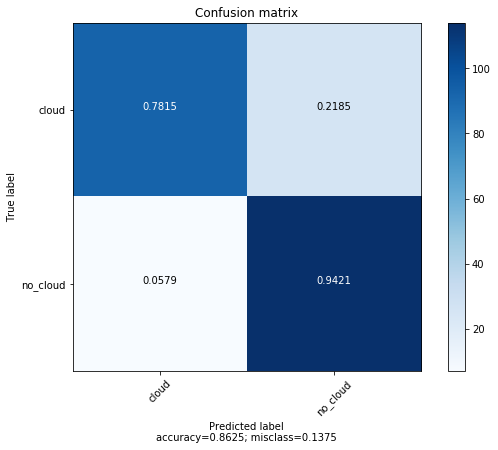

In [40]:
cm = confusion_matrix(y_actual_test, y_pred_test)
# Put in same format as google automl
cm = np.array(
    [[cm[1][1], cm[1][0]],
     [cm[0][1], cm[0][0]]
])
plot_confusion_matrix(cm, target_names=['cloud', 'no_cloud'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)

In [45]:
precision, recall, thresholds = precision_recall_curve(y_actual_test, y_pred_probs_test)

In [46]:
precision = precision[:-1]
recall = recall[:-1]
df = pd.concat([
    pd.DataFrame({'stat_name': ['precision' for _ in range(len(precision))],
                  'stat_value': precision,
                  'threshold': thresholds}),
    pd.DataFrame({'stat_name': ['recall' for _ in range(len(precision))],
                  'stat_value': recall,
                  'threshold': thresholds})    
])

In [41]:
df = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds})
df[df['threshold'] > .18]

,precision,recall,threshold
74,0.851240,0.865546,0.183968
75,0.858333,0.865546,0.192485
76,0.865546,0.865546,0.192663
77,0.864407,0.857143,0.196512
78,0.871795,0.857143,0.203125
...,...,...,...
190,1.000000,0.042017,0.998844
191,1.000000,0.033613,0.998897
192,1.000000,0.025210,0.999755
193,1.000000,0.016807,0.999910


Text(0.5, 1.0, 'Precision/Recall per Threshold')

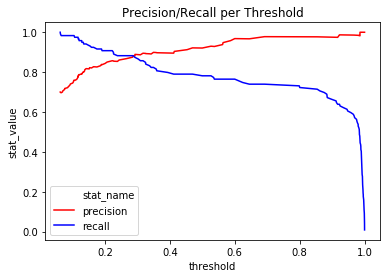

In [47]:
ax = sns.lineplot(y=df['stat_value'], x=df['threshold'], hue=df['stat_name'], 
                  palette={'precision': 'red', 'recall': 'blue'})
ax.set_title('Precision/Recall per Threshold')
# ax.fill_between(recall,precision, color="darkblue", alpha=0.3)

In [ ]:
# Hyperparameter tuning

In [3]:
experiments = [
    "cloud_and_shadow_cnn_bn_hopt_lr_0.00012387_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00015907_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.0001945_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00023558_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00024361_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.0002532_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00027934_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00037462_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00041657_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00043806_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00049497_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00057232_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00063454_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00065432_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00084517_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.0008693_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00093852_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00136203_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00153225_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00168857_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00219341_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00244096_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00323063_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.0035308_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00397654_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00496855_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00541214_optimizer_SGD_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00882552_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00931584_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_0.00973927_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_1.032e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_1.146e-05_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_1.296e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_2.053e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_2.086e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_2.383e-05_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_3.665e-05_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_4.39e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_5.246e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_5.635e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_5.673e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_5.984e-05_optimizer_Adam_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_8.667e-05_optimizer_RMSprop_2020_2_13",
"cloud_and_shadow_cnn_bn_hopt_lr_9.781e-05_optimizer_RMSprop_2020_2_13",
]

In [3]:
experiments = [
"keras_cnn_bn_hopt_lr_0.00010297_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.0001118_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00012048_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00016145_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00016852_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00018246_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00027695_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00028531_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00030841_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00037691_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00050827_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00053454_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00054753_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00056998_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00067198_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00072196_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00078287_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00089769_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00098156_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00124899_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00131306_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.0014796_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00164205_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00184748_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00222851_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00238071_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00283816_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00351931_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00382567_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00491674_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00499853_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00604878_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00806118_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00872263_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_0.00992734_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_1.79e-05_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_2.313e-05_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_2.693e-05_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_2e-06_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_3.05e-06_optimizer_Adam_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_4.564e-05_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_5.896e-05_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_6.19e-06_optimizer_RMSprop_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_6.768e-05_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_7.667e-05_optimizer_SGD_2020_2_14_metadata.json",
"keras_cnn_bn_hopt_lr_8.53e-06_optimizer_Adam_2020_2_14_metadata.json",    
]

In [42]:
experiment = "cloud_and_shadow_keras_cnn_bn_hopt_lr_0.00222851_optimizer_Adam_2020_2_14_metadata.json"
local_filename = f'/tmp/{experiment}.json'
blob = bucket.blob(f"model/models/{experiment}")
blob.upload_from_filename(local_filename)

In [8]:
len_one_keys = ['data', 'data_prep', 'experiment_name', 'experiment_start_time', 'model', 'random_state', 'epoch_with_best_model', 'epochs_trained', 'optimizer', 'n_epochs', 'early_stopping_patience', 'learning_rate', 'elapsed_train_time', 'accuracy_train', 'f1_score_train', 'train_loss', 'loss', 'accuracy_valid', 'f1_score_valid']
long_keys = ['history', 'confusion_matrix', 'precision_recall_curve', 'y_actual_train', 'y_pred_train', 'y_pred_probs_train', 'y_actual_valid', 'y_pred_valid', 'y_pred_probs_valid']
serializable_results_list = []

for experiment in experiments:
    experiment = f"{project_name}_{experiment}"
    local_filename = f'/tmp/{experiment}.json'
    blob = bucket.blob(f"model/models/{experiment}")
    blob.download_to_filename(local_filename)

    with open(local_filename) as fileobj:
        results = json.load(fileobj)  

    try:
        serializable_results = {k: results[k] for k in len_one_keys}
        for key in long_keys:
            serializable_results[key] = json.dumps(results[key])
        serializable_results_list.append(serializable_results)
    except KeyError:
        print('keyerror')
        print(experiment)
    
df = pd.DataFrame(serializable_results_list, index=[num for num in range(len(serializable_results_list))])

In [26]:
df = df[(df['n_epochs'] > 2) & (df['accuracy_valid'] > .77)]
d = df[['experiment_name', 'optimizer', 'learning_rate', 'elapsed_train_time', 'n_epochs', 'accuracy_train', 'accuracy_valid']].sort_values(
    by='accuracy_valid', ascending=False)
d

,experiment_name,optimizer,learning_rate,elapsed_train_time,n_epochs,accuracy_train,accuracy_valid
24,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.002228...,Adam,0.002229,492.635518,100,0.929208,0.944664
17,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.000897...,RMSprop,0.000898,743.985975,100,0.937598,0.944664
19,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.001248...,RMSprop,0.001249,517.621637,100,0.947037,0.940711
11,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.000534...,Adam,0.000535,530.712421,100,0.938647,0.940711
13,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.000569...,RMSprop,0.000570,442.761189,100,0.923440,0.936759
22,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.001642...,RMSprop,0.001642,462.391976,100,0.910855,0.932806
12,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.000547...,RMSprop,0.000548,645.736338,100,0.949659,0.932806
18,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.000981...,RMSprop,0.000982,449.507525,100,0.928159,0.932806
16,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.000782...,RMSprop,0.000783,522.062560,100,0.941793,0.928854
9,cloud_and_shadow_keras_cnn_bn_hopt_lr_0.000376...,RMSprop,0.000377,390.634282,100,0.917147,0.928854


cloud_and_shadow_keras_cnn_bn_hopt_lr_0.00222851_optimizer_Adam_2020_2_14


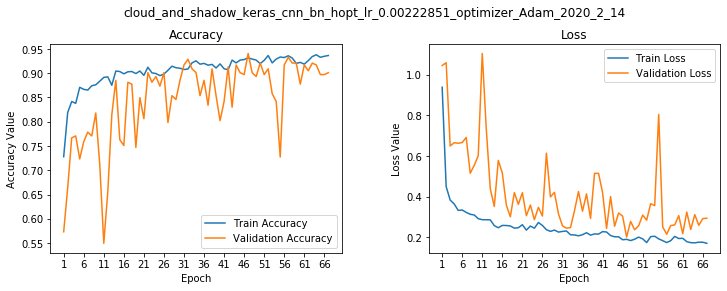

In [30]:
best_experiment_name = d.iloc[0]['experiment_name']
print(best_experiment_name)
best_experiment_result = df[df['experiment_name'] == best_experiment_name]
best_experiment_history = json.loads(best_experiment_result['history'].values[0])
graph_model_history(best_experiment_history, best_experiment_name)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3537bc4e48>]],
      dtype=object)

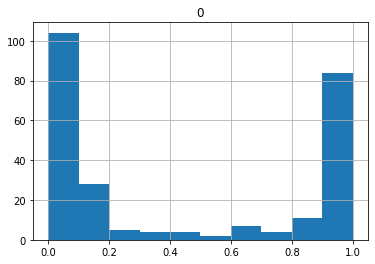

In [28]:
best_experiment_preds = json.loads(best_experiment_result['y_pred_probs_valid'].values[0])
pd.DataFrame(best_experiment_preds).hist()

In [31]:
model, model_base_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "h5", load_model, gcs_model_dir,
                                                             best_experiment_name)

binary_crossentropy - cnn with regularization and augmentation 0.2404575
accuracy 0.9051383399209486


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a7e92c048>]],
      dtype=object)

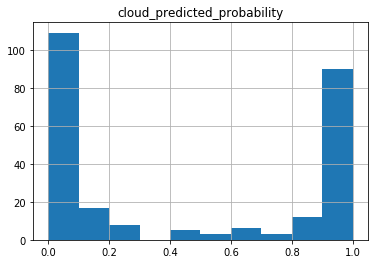

In [32]:
valid_generator = get_image_dataset(x=x_valid, y=y_valid, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
y_actual_valid, y_pred_valid, y_pred_probs_valid = get_predictions_for_dataset(valid_generator, model) 

print('binary_crossentropy - cnn with regularization and augmentation', 
      binary_crossentropy(y_actual_valid, y_pred_probs_valid).numpy())
print('accuracy', accuracy_score(y_actual_valid, y_pred_valid))

pd.DataFrame({'cloud_predicted_probability': y_pred_probs_valid}).hist()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
binary_crossentropy - cnn with regularization and augmentation 0.29700896
accuracy 0.8916666666666667


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f353cabd630>]],
      dtype=object)

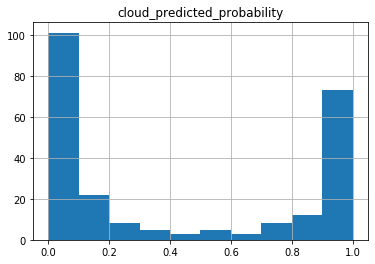

In [32]:
test_generator = get_image_dataset(x=x_test, y=y_test, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
y_actual_test, y_pred_test, y_pred_probs_test = get_predictions_for_dataset(test_generator, model) 

print('binary_crossentropy - cnn with regularization and augmentation', 
      binary_crossentropy(y_actual_test, y_pred_probs_test).numpy())
print('accuracy', accuracy_score(y_actual_test, y_pred_test))

pd.DataFrame({'cloud_predicted_probability': y_pred_probs_test}).hist()

In [35]:
precision, recall, thresholds = precision_recall_curve(y_actual_test, y_pred_probs_test)

precision = precision[:-1]
recall = recall[:-1]
df = pd.concat([
    pd.DataFrame({'stat_name': ['precision' for _ in range(len(precision))],
                  'stat_value': precision,
                  'threshold': thresholds}),
    pd.DataFrame({'stat_name': ['recall' for _ in range(len(precision))],
                  'stat_value': recall,
                  'threshold': thresholds})    
])
ax = sns.lineplot(y=df['stat_value'], x=df['threshold'], hue=df['stat_name'], 
                  palette={'precision': 'red', 'recall': 'blue'})
ax.set_title('Precision/Recall per Threshold')
# ax.fill_between(recall,precision, color="darkblue", alpha=0.3)

In [33]:
average_precision_score(y_actual_test, y_pred_probs_test)

0.9552918458324685

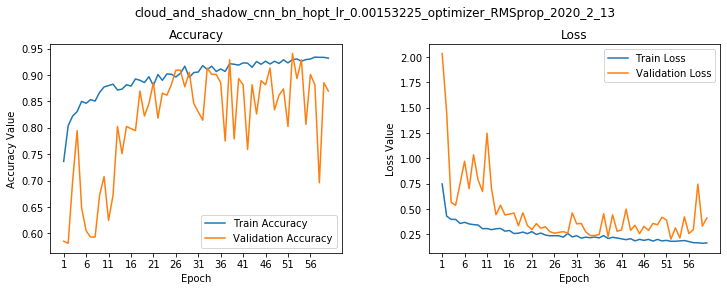

In [6]:
second_best_experiment_name = d.iloc[1]['experiment_name']
best_experiment_history = json.loads(df[df['experiment_name'] == second_best_experiment_name]['history'].values[0])
graph_model_history(best_experiment_history, second_best_experiment_name)

In [ ]:
rms_model, rms_model_base_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "h5", load_model, gcs_model_dir,
                                                             second_best_experiment_name)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
binary_crossentropy - cnn with regularization and augmentation 0.2865209
accuracy 0.8791666666666667
average_precision_score 0.9608923169575532


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb94b8ba390>]],
      dtype=object)

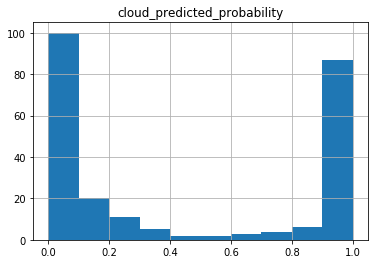

In [9]:
test_generator = get_image_dataset(x=x_test, y=y_test, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
y_actual_test, y_pred_test, y_pred_probs_test = get_predictions_for_dataset(test_generator, rms_model) 

print('binary_crossentropy - cnn with regularization and augmentation', 
      binary_crossentropy(y_actual_test, y_pred_probs_test).numpy())
print('accuracy', accuracy_score(y_actual_test, y_pred_test))
print('average_precision_score', average_precision_score(y_actual_test, y_pred_probs_test))

pd.DataFrame({'cloud_predicted_probability': y_pred_probs_test}).hist()

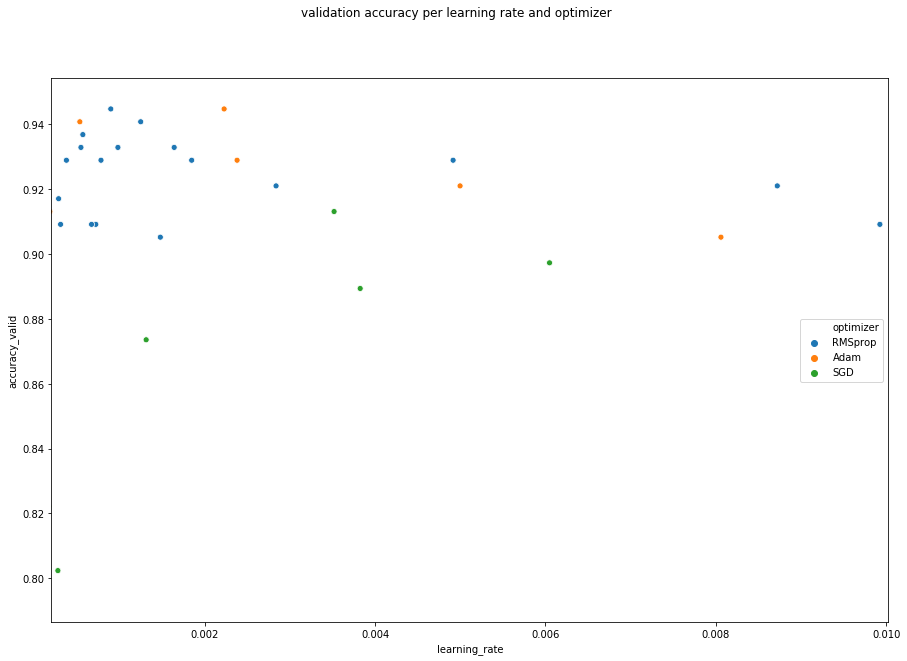

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
fig.suptitle('validation accuracy per learning rate and optimizer')
ax.set_xlim([df['learning_rate'].min() * 100, df['learning_rate'].max() * 1.01])
ax.set_ylim([df['accuracy_valid'].min(), df['accuracy_valid'].max() * 1.01])
sns.scatterplot(x=d['learning_rate'], y=d['accuracy_valid'], hue=d['optimizer'], ax=ax)
ax.legend(loc='center right')

In [43]:
# Best performing model on all data
experiment = "cloud_and_shadow_keras_cnn_bn_large_data_lr_0.00222851_optimizer_Adam_2020_2_14"
model, metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "h5", load_model, gcs_model_dir,
                                                             experiment)

In [52]:
metadata['accuracy_train']

0.9292427497314716

binary_crossentropy - cnn with regularization and augmentation 0.2165131
accuracy 0.9208333333333333
average_precision_score 0.9751448644812428


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f353aa58b70>]],
      dtype=object)

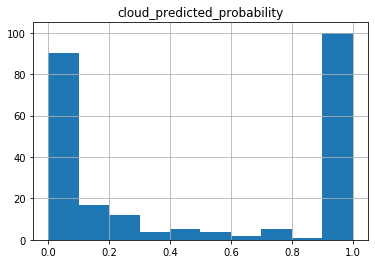

In [45]:
test_generator = get_image_dataset(x=x_test, y=y_test, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
y_actual_test, y_pred_test, y_pred_probs_test = get_predictions_for_dataset(test_generator, model) 

print('binary_crossentropy - cnn', 
      binary_crossentropy(y_actual_test, y_pred_probs_test).numpy())
print('accuracy', accuracy_score(y_actual_test, y_pred_test))
print('average_precision_score', average_precision_score(y_actual_test, y_pred_probs_test))

pd.DataFrame({'cloud_predicted_probability': y_pred_probs_test}).hist()

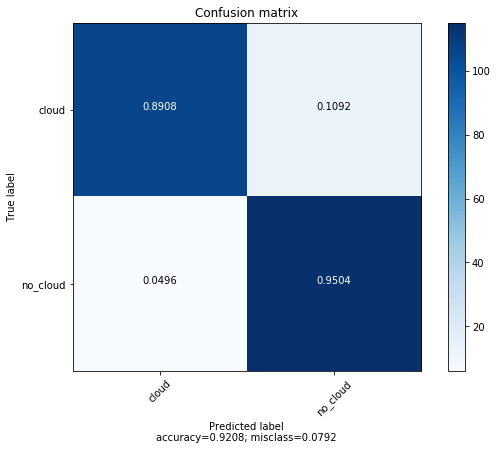

In [49]:
cm = confusion_matrix(y_actual_test, y_pred_test)
# Put in same format as google automl
cm = np.array(
    [[cm[1][1], cm[1][0]],
     [cm[0][1], cm[0][0]]
])
plot_confusion_matrix(cm, target_names=['cloud', 'no_cloud'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)

Text(0.5, 0, 'Confidence')

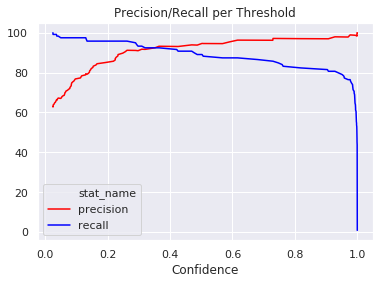

In [56]:
precision, recall, thresholds = precision_recall_curve(y_actual_test, y_pred_probs_test)

precision = precision[:-1]
recall = recall[:-1]
df = pd.concat([
    pd.DataFrame({'stat_name': ['precision' for _ in range(len(precision))],
                  'stat_value': precision * 100,
                  'threshold': thresholds}),
    pd.DataFrame({'stat_name': ['recall' for _ in range(len(precision))],
                  'stat_value': recall * 100,
                  'threshold': thresholds})    
])
sns.set()
ax = sns.lineplot(y=df['stat_value'], x=df['threshold'], hue=df['stat_name'], 
                  palette={'precision': 'red', 'recall': 'blue'})
ax.set_title('Precision/Recall per Threshold')
ax.set_ylabel('')
ax.set_xlabel('Confidence')
# ax.fill_between(recall,precision, color="darkblue", alpha=0.3)

In [69]:
df = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds})
df[df['threshold'] > .25]

,precision,recall,threshold
63,0.904762,0.957983,0.256481
64,0.912000,0.957983,0.262246
65,0.911290,0.949580,0.289504
66,0.910569,0.941176,0.292955
67,0.909836,0.932773,0.297493
...,...,...,...
184,1.000000,0.042017,0.999999
185,1.000000,0.033613,1.000000
186,1.000000,0.025210,1.000000
187,1.000000,0.016807,1.000000


# Transfer Learning

In [70]:
# experiment_name = "cloud_and_shadow_resnet_v2_with_aug_2020_2_15"
experiment_name = "cloud_and_shadow_resnet_v2_with_aug_early_stopping_20_lr_3e-4_2020_2_08"
# model2, metadata2 = get_model_and_metadata_from_gcs(
#     bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)

gcs_model_and_metadata_filepath = os.path.join(gcs_model_dir, experiment_name)
gcs_metadata_filepath = f"{gcs_model_dir}/{experiment_name}_metadata.json"
metadata_filepath = f"{model_dir}/{experiment_name}_metadata.json"

gcs_metadata_blob = bucket.blob(gcs_metadata_filepath)

if gcs_metadata_blob.exists():
    print('Downloading model blob.')
    gcs_metadata_blob.download_to_filename(metadata_filepath)

    with open(metadata_filepath, 'r') as json_file:
        model_metadata = json.load(json_file)
        
keys = ['experiment_name', 'n_epochs', 'epochs_trained', 'learning_rate', 'early_stopping_patience', 'elapsed_train_time', 'accuracy_valid', 
        'accuracy_train', 'f1_score_train', 'f1_score_valid',
        'loss']
df2 = pd.DataFrame([{key: model_metadata.get(key) for key in keys}])

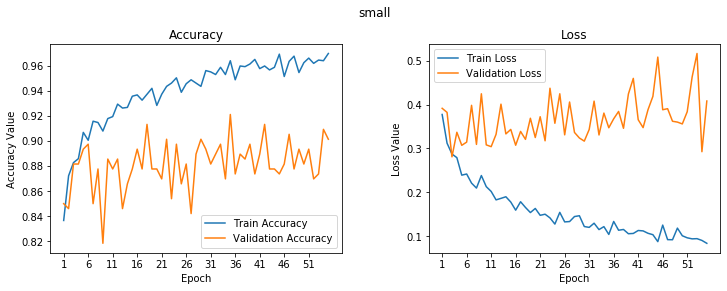

In [82]:
graph_model_history(model_metadata['history'], 'small')

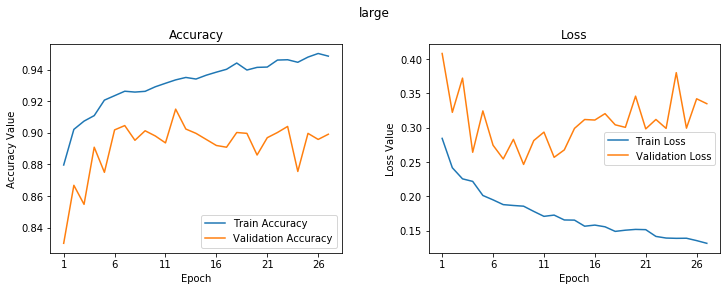

In [83]:
graph_model_history(metadata['history'], 'large')

In [44]:
experiment_name = "cloud_and_shadow_resnet_v2_large_lr_1e-4_2020_2_18"  
model, metadata = get_model_and_metadata_from_gcs(
    bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)
keys = ['experiment_name', 'n_epochs', 'epochs_trained', 'learning_rate', 'early_stopping_patience', 'elapsed_train_time', 'accuracy_valid', 
        'accuracy_train', 'f1_score_train', 'f1_score_valid',
        'loss']
df = pd.DataFrame([{key: metadata.get(key) for key in keys}])

In [80]:
df

,experiment_name,n_epochs,epochs_trained,learning_rate,early_stopping_patience,elapsed_train_time,accuracy_valid,accuracy_train,f1_score_train,f1_score_valid,loss
0,cloud_and_shadow_resnet_v2_large_lr_1e-4_2020_...,100,27,0.0001,15,4941.45788,0.904605,0.914205,0.91299,0.901024,0.280935


In [79]:
for idx, val in enumerate(metadata['history']['val_accuracy']):
    if val >= metadata['accuracy_valid']:
        print(idx, val)

6 0.9046052694320679
11 0.9150219559669495


binary_crossentropy - cnn with regularization and augmentation 0.24007708
accuracy 0.9173913043478261
average_precision_score 0.9763072673068851


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc438ea4940>]],
      dtype=object)

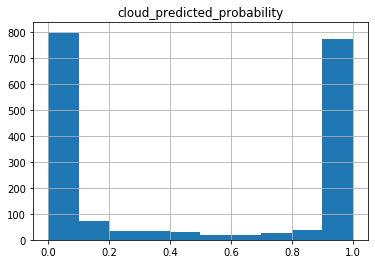

In [45]:
resnet_v2_input_shape = (224, 224, 3)

def resnet_v2_image_processor(image):
    resized_img = cv2.resize(image, dsize=(resnet_v2_input_shape[0], resnet_v2_input_shape[1]), 
                             interpolation=cv2.INTER_CUBIC)
    normalized_img = cv2.normalize(resized_img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    return resnet_v2.preprocess_input(normalized_img)

test_generator = get_image_dataset(x=x_test, y=y_test, augmentations=None, image_processor=resnet_v2_image_processor,
                                    band_stats=band_stats, batch_size=batch_size)
y_actual_test, y_pred_test, y_pred_probs_test = get_predictions_for_dataset(test_generator, model) 

print('binary_crossentropy - cnn with regularization and augmentation', 
      binary_crossentropy(y_actual_test, y_pred_probs_test).numpy())
print('accuracy', accuracy_score(y_actual_test, y_pred_test))
print('average_precision_score', average_precision_score(y_actual_test, y_pred_probs_test))

pd.DataFrame({'cloud_predicted_probability': y_pred_probs_test}).hist()

In [46]:
sklearn.metrics.precision_recall_fscore_support(y_actual_test, y_pred_test, average='binary') 

(0.9427917620137299, 0.8898488120950324, 0.9155555555555556, None)

In [ ]:
pd.DataFrame(
    index=['hp_tuned_keras_cnn', 'resnet50_v2', 'google_automl']
)



